# OPEN AND PLOT ARIA PRODUCTS

In [70]:
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
from shapely.geometry import Polygon
import cartopy.feature as cfeature
from osgeo import gdal
from cartopy import crs as ccrs
from pyproj import CRS
import pyproj
import numpy as np

In [2]:
# Use gdal to open raster data
# URL: https://gdal.org/tutorials/index.html

def get_raster_crs(gdal_object):
    projection = gdal_object.GetProjection() # raster projection
    crs = CRS.from_wkt(projection) if projection else None
    return crs

def get_raster_dimensions(gdal_object):
    band_count = gdal_object.RasterCount
    xsize = gdal_object.RasterXSize # raster width
    ysize = gdal_object.RasterYSize # raster length
    return band_count, ysize, xsize

def get_raster_extent(gdal_object):
    # Get raster geographical information
    trans = gdal_object.GetGeoTransform()

    snwe = [trans[3] + gdal_object.RasterYSize * trans[5], trans[3],
              trans[0], trans[0] + gdal_object.RasterXSize * trans[1]]
    
    return [snwe[2], snwe[3], snwe[0], snwe[1]]


# Lets OPEN some raster (geotif : .tif) from ARIA archive

In [3]:
# open raster with gdal 
# NOTE: we can open it directly from web using /vsicurl/url_to_raster

raster_url = 'https://d1z62tir4fw0q0.cloudfront.net/202009-Bobcat_Fire/ARIA_S1_DPM_Sep14-Sep20_7am.tif'

aria_ds = gdal.Open('/vsicurl/' + raster_url)

In [4]:
# Let get the needed raster metadata
metadata = aria_ds.GetMetadata()

extent = get_raster_extent(aria_ds)
# Raster length, width
n_layers, length, width  = get_raster_dimensions(aria_ds)

# Get raster projection/CRS
raster_crs = get_raster_crs(aria_ds)

# Lets print
print('#'*100)
print('Raster URL:  ', raster_url)
print('Raster Metadata:  ', metadata)
print('Raster Extent:  ', extent)
print('Raster Number of Layers:  ', n_layers)
print('Raster Length:  ', length)
print('Raster Width:  ', width)
print('Raster CRS:  EPSG',raster_crs.to_epsg())
print('#'*100)

####################################################################################################
Raster URL:   https://d1z62tir4fw0q0.cloudfront.net/202009-Bobcat_Fire/ARIA_S1_DPM_Sep14-Sep20_7am.tif
Raster Metadata:   {'AREA_OR_POINT': 'Area'}
Raster Extent:   [-118.301617623, -117.216895401, 33.892715405, 34.556326516]
Raster Number of Layers:   4
Raster Length:   2389
Raster Width:   3905
Raster CRS:  EPSG 4326
####################################################################################################


In [5]:
#Get the raster array
raster_array = aria_ds.ReadAsArray()

print('Raster dim:', raster_array.shape)

Raster dim: (4, 2389, 3905)


In [6]:
# Let get the event name and date from raster filename string
event_name = raster_url.split('/')[-2].split('-')[-1]
event_date = dt.strptime(raster_url.split('/')[-2].split('-')[0],'%Y%m')
day = int(raster_url.split('/')[-1].split('-')[-1].split('_')[0].split('p')[-1])
event_date += timedelta(days=day-1)
event_date = dt.strftime(event_date,'%Y-%m-%d')

print('Event Name:', event_name)
print('Event Date:', event_date)

Event Name: Bobcat_Fire
Event Date: 2020-09-20


# Let do simple plot

In [68]:
#States - using https://www.naturalearthdata.com/
states_provinces = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale='50m',
                facecolor='none')

def plot_inset_globe(aoi_extent:list, ax):
    
    #Define aoi extent Polygon
    aoi_polygon = Polygon([[aoi_extent[0], aoi_extent[2]], 
                       [aoi_extent[1], aoi_extent[2]], 
                       [aoi_extent[1], aoi_extent[3]], 
                       [aoi_extent[0], aoi_extent[3]]])

    central_lon = np.mean(aoi_extent[:2])
    central_lat = np.mean(aoi_extent[2:])

    ortho = ccrs.Orthographic(central_lon, central_lat)
    ax.projection = ortho

    # Map
    ax.coastlines(edgecolor='#E8EAED', linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, facecolor='#2A2B2E',zorder=0)
    ax.add_feature(cfeature.LAND, edgecolor='#E8EAED', facecolor='#E8EAED', zorder=1)
    ax.add_feature(cfeature.LAKES, facecolor='#2A2B2E', zorder=1)
    ax.add_feature(cfeature.BORDERS,edgecolor='black', linewidth=0.2, zorder=2)

    # Plot aoi
    ax.add_geometries([aoi_polygon], 
                crs=ccrs.Geodetic(),
                linewidth=1,
                zorder=3,
                facecolor='red', 
                edgecolor='red', 
                alpha=0.2)

    ax.add_geometries([aoi_polygon], 
                crs=ccrs.Geodetic(),
                linewidth=2,
                zorder=3,
                facecolor='none', 
                edgecolor='red', 
                alpha=1)

def round_to_1(x):
    """Return the most significant digit of input number"""
    digit = int(np.floor(np.log10(abs(x))))
    return round(x, -digit)    

# Scalebar example from Mintpy 
# https://github.com/insarlab/MintPy/blob/c174dc82cb14f413998dfe1426a6e8e2d8305b37/src/mintpy/utils/map.py#L116
def draw_scalebar(ax, geo_box, unit='degrees', loc=[0.2, 0.2, 0.1], labelpad=0.05, font_size=12, color='k'):
    """draw a simple map scale from x1,y to x2,y in map projection coordinates, label it with actual distance
    ref_link: http://matplotlib.1069221.n5.nabble.com/basemap-scalebar-td14133.html
    Parameters: ax       : matplotlib.pyplot.axes object
                geo_box  : tuple of 4 float in (x0, y0, x1, y1) for (W, N, E, S) in degrees / meters
                unit     : str, coordinate unit - degrees or meters
                loc      : list of 3 float in (length, y, x) of scale bar location:
                           length = ratio of the total width
                           y / x = axes fraction of the scale bar center
                labelpad : float
    Returns:    ax       : matplotlib.pyplot.axes object
    Example:    from mintpy.utils import plot as pp
                pp.draw_scale_bar(ax, geo_box)
    """
    geod = pyproj.Geod(ellps='WGS84')
    ax = ax if ax else plt.gca()

    ## location - center
    lon_c = geo_box[0] + loc[1] * (geo_box[2] - geo_box[0])
    lat_c = geo_box[3] + loc[2] * (geo_box[1] - geo_box[3])

    ## length
    # 1. calc scene width in meters
    if unit.startswith('meter'):
        scene_width = geo_box[2] - geo_box[0]
    elif unit.startswith('deg'):
        scene_width = geod.inv(geo_box[0], geo_box[3],
                               geo_box[2], geo_box[3])[2]

        # do not plot scalebar if the longitude span > 30 deg
        if (geo_box[2] - geo_box[0]) > 30:
            return ax

    # 2. convert length ratio to length in meters
    length_meter = round_to_1(scene_width * loc[0])
    # round to the nearest km
    if length_meter > 1000.0:
        length_meter = np.rint(length_meter/1000.0)*1000.0

    # 3. convert length in meters to length in display coord unit
    if unit.startswith('deg'):
        lon_c2 = geod.fwd(lon_c, lat_c, 90, length_meter)[0]
        length_disp = np.abs(lon_c - lon_c2)
    elif unit.startswith('meter'):
        length_disp = length_meter

    ## starting/ending longitude
    lon0 = lon_c - length_disp / 2.0
    lon1 = lon_c + length_disp / 2.0

    ## plot scale bar
    ax.plot([lon0, lon1], [lat_c, lat_c], color=color)
    ax.plot([lon0, lon0], [lat_c, lat_c + 0.1*length_disp], color=color)
    ax.plot([lon1, lon1], [lat_c, lat_c + 0.1*length_disp], color=color)

    ## plot scale bar label
    unit = 'm'
    if length_meter >= 1000.0:
        unit = 'km'
        length_meter *= 0.001
    txt_offset = (geo_box[1] - geo_box[3]) * labelpad

    ax.text(x=lon0+length_disp/2.0,
            y=lat_c+txt_offset,
            s=f'{length_meter:.0f} {unit}',
            va='center',
            ha='center',
            fontsize=font_size,
            color=color)

    return ax


In [13]:
#Basemap
from cartopy.io.img_tiles import GoogleTiles

### Other links QuickMap
# https://qms.nextgis.com/#
#
wmts_urls = ['https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
             'http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}']

basemap_google = GoogleTiles(url = wmts_urls[0])
basemap_esri = GoogleTiles(url = wmts_urls[1])

#Another option for basemaps
#import contextily as cx
#https://contextily.readthedocs.io/en/latest/

In [24]:
# https://geoffboeing.com/2016/11/osmnx-python-street-networks/
# https://automating-gis-processes.github.io/CSC18/lessons/L3/retrieve-osm-data.html
import osmnx as ox
G = ox.graph_from_bbox(extent[2], extent[3], extent[0], extent[1], network_type='drive')

In [41]:
nodes, edges = ox.graph_to_gdfs(G)
edges

osmid   
u           v           key                                                      
667802      54266508    0                                  [7067093, 35345055]  \
            667804      0           [35741241, 35741242, 98244507, 1032018695]   
667804      3470745314  0                                             35741242   
667816      392513275   0                                            157515743   
            59664356    0    [336934178, 35345159, 35345160, 35345164, 1031...   
...                                                                        ...   
10230981775 122840034   0                                           1118657506   
10230981777 10230981761 0                                           1118657527   
            10230981775 0                             [1118657526, 1118657502]   
10804394605 123004688   0                                             13373020   
10839184491 122885638   0                                            350944849   

                            bridge  oneway        highway reversed    length   
u           v           key                                                    
667802      54266508    0      yes    True  motorway_link    False   456.351  \
            667804      0      yes    True       motorway    False   882.995   
667804      3470745314  0      NaN    True       motorway    False  1911.772   
667816      392513275   0      NaN    True  motorway_link    False   262.135   
            59664356    0      yes    True       motorway    False  1430.690   
...                            ...     ...            ...      ...       ...   
10230981775 122840034   0      NaN    True          trunk    False    58.583   
10230981777 10230981761 0      NaN   False          trunk     True    14.472   
            10230981775 0      NaN    True          trunk    False   158.125   
10804394605 123004688   0      NaN   False    residential    False    83.624   
10839184491 122885638   0      NaN   False    residential     True    97.062   

                                                                      geometry   
u           v           key                                                      
667802      54266508    0    LINESTRING (-117.43338 34.18496, -117.43448 34...  \
            667804      0    LINESTRING (-117.43338 34.18496, -117.43438 34...   
667804      3470745314  0    LINESTRING (-117.43996 34.17919, -117.44107 34...   
667816      392513275   0    LINESTRING (-117.51023 34.13616, -117.50843 34...   
            59664356    0    LINESTRING (-117.51023 34.13616, -117.50418 34...   
...                                                                        ...   
10230981775 122840034   0    LINESTRING (-118.03713 34.54274, -118.03697 34...   
10230981777 10230981761 0    LINESTRING (-118.03543 34.54275, -118.03527 34...   
            10230981775 0    LINESTRING (-118.03543 34.54275, -118.03554 34...   
10804394605 123004688   0    LINESTRING (-118.23192 34.22794, -118.23283 34...   
10839184491 122885638   0    LINESTRING (-118.18315 34.51605, -118.18421 34...   

                            lanes     ref                 name maxspeed   
u           v           key                                               
667802      54266508    0     NaN     NaN                  NaN      NaN  \
            667804      0       4    I 15      Ontario Freeway   70 mph   
667804      3470745314  0       4    I 15      Ontario Freeway   70 mph   
667816      392513275   0       3     NaN                  NaN      NaN   
            59664356    0       4  CA 210     Foothill Freeway   65 mph   
...                           ...     ...                  ...      ...   
10230981775 122840034   0       3     NaN  Pearblossom Highway   60 mph   
10230981777 10230981761 0     NaN     NaN  Pearblossom Highway   60 mph   
            10230981775 0       2     NaN  Pearblossom Highway   60 mph   
10804394605 123004688   0     NaN     NaN        Kemper Avenue      NaN  

/Users/govorcin/insar/miniconda3/envs/vlm/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/govorcin/insar/miniconda3/envs/vlm/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/govorcin/insar/miniconda3/envs/vlm/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:801: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the 

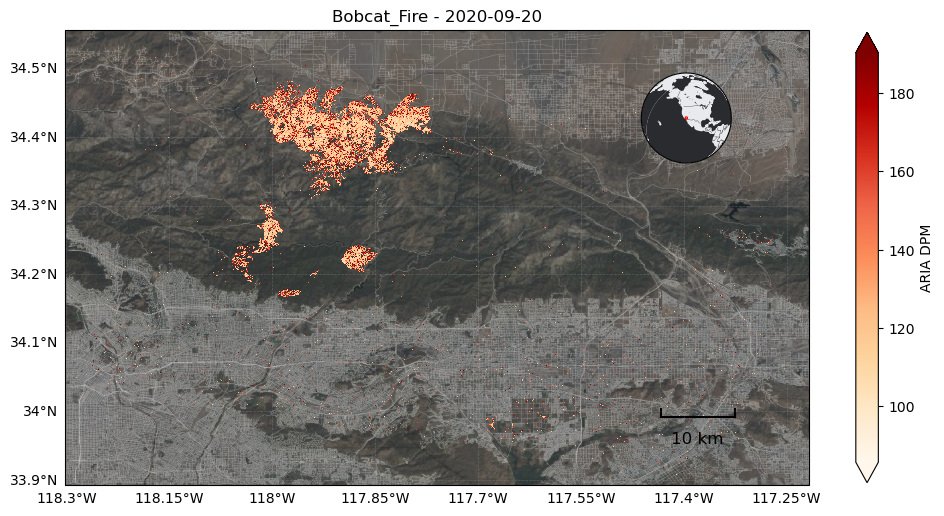

In [77]:
fig, ax = plt.subplots(1, figsize=[12,9], subplot_kw=dict(projection=proj_obj))

#add basemap
ax.add_image(basemap_google, 10, zorder=0)
ax.add_image(basemap_esri, 10, zorder=0., cmap='gray', alpha=0.7) # blot dark ESRI basemap over Google satellite

#Add ARIA DPM map
image = ax.imshow(np.ma.masked_less_equal(np.nanmean(raster_array, axis=0),80), extent=extent, 
            cmap='OrRd', interpolation='nearest', zorder=2)

## Plot colorbar
fig.colorbar(image, ax=ax, location='right', label='ARIA DPM', shrink=0.65, extend='both')

#Add streets from OSM
edges.to_crs(epsg=4326).plot(ax=ax, zorder=1, edgecolor='white', 
                             facecolor=None, alpha=0.9, linewidth=0.05)


#Add scalebar 
draw_scalebar(ax, (extent[0], extent[2], extent[1], extent[3]), loc=[0.15, 0.85,0.85])

## GRID
grid_kwargs= dict(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

grids = ax.gridlines(**grid_kwargs)
ax.coastlines() 
ax.set_title(f'{event_name} - {event_date}')

grids.xlabels_top = False
grids.ylabels_right = False
grids.xlines = True
grids.xlabel_style = {'size': 15, 'color': 'gray'}
grids.xlabel_style = {'color': 'black', 'weight': 'normal'}

ax.set_xlim(extent[:2])
ax.set_ylim(extent[2:])

#add inset
ax2 = plt.axes([0.58, 0.60, 0.1, 0.1], projection=ccrs.Orthographic(),anchor='NE')
plot_inset_globe(extent,ax=ax2)